Predictive analytics is a powerful approach for extracting insights from data and guiding data-informed decision-making. In this notebook, I delve into predictive analysis using a Facebook dataset as the foundation. My primary focus is on predicting "Engagements," a critical metric in the realm of social media. Engagements encompass various interactions with content, such as likes, shares, reactions, comments, and saves. These interactions signify how many individuals have not only viewed but actively engaged with the content. I leverage the carefully selected features retained throughout my analysis to achieve these predictions.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
path = "C:/Users/user/Downloads/DiceyTechHack"
data = pd.read_csv(path +"/FacebookData.csv")

In [3]:
data.head(2)

,Date,Content Type,Sent by,Post,Impressions,Viral Impressions,Non-viral Impressions,Fan Impressions,Non-fan Impressions,Reach,...,95% Video Views,Video Length (Seconds),Average Video Time Watched (Seconds),Video View Time (Seconds),Unique Video Views,Unique 10-Second Video Views,Unique Full Video Views,Unique Organic 95% Video Views,Unique Paid 95% Video Views,Tags
0,12/17/2022 17:08,Video,Damilare Oyekanmi,"We celebrated recently with Novare, one of our...",207378,5,207373,1147,206231,207378,...,19,84,3,14825,975,263,62,19,0,CIB Posts
1,5/4/2019 10:01,Photo,,N5k can get you started today. Call 01 280 126...,125784,23926,101858,103287,22497,92009,...,0,0,0,0,0,0,0,0,0,Other


In [4]:
data["Date"] = pd.to_datetime(data["Date"])
data["PostHour"] = data["Date"].dt.hour
data["PostMonth"] = data["Date"].dt.month_name()
data["PostYear"] = data["Date"].dt.year
data["num_post_words"] = data["Post"].str.len()

In [5]:
data["num_post_words"].fillna(0, inplace=True)

In [6]:
data.isnull().sum()

Date                0
Content Type        0
Sent by             0
Post              250
Impressions         0
                 ... 
Tags                0
PostHour            0
PostMonth           0
PostYear            0
num_post_words      0
Length: 73, dtype: int64

In [7]:
data.drop("Post", axis=1, inplace=True)
data.drop("Date", axis=1, inplace=True)

In [8]:
data.dtypes

Content Type              object
Sent by                   object
Impressions                int64
Viral Impressions          int64
Non-viral Impressions      int64
                          ...   
Tags                      object
PostHour                   int64
PostMonth                 object
PostYear                   int64
num_post_words           float64
Length: 71, dtype: object

In [9]:
numeric_data = data.select_dtypes(include=[np.number])
cat_data = data.select_dtypes(exclude=[np.number])
print ("There are {} numeric and {} categorical columns in train data".format(numeric_data.shape[1],cat_data.shape[1]))

There are 67 numeric and 4 categorical columns in train data


In [10]:
corr = numeric_data.corr()
print(corr["Engagements"].sort_values(ascending = False))

Engagements                         1.000000
Reactions                           0.959632
Likes                               0.958649
Comments                            0.628941
Shares                              0.601367
                                      ...   
Engagement Rate (per Impression)    0.009187
Unique Paid 95% Video Views         0.000775
Click-Through Rate                 -0.002047
PostYear                           -0.003878
num_post_words                     -0.021241
Name: Engagements, Length: 67, dtype: float64


In [11]:
X = data.drop(["Engagements"],axis=1)
y = data["Engagements"]

DATA PREPROCESSING

In [12]:
from sklearn.preprocessing import LabelEncoder

In [13]:
le = LabelEncoder()

def processing_data(dataa):
     processed_data = data.copy()

     categ = ["Content Type",
              "Sent by",
              "Tags",
              "PostMonth"]
    
     for col in categ:
        processed_data[col] = le.fit_transform(processed_data[col])

     return pd.DataFrame(processed_data, columns = processed_data.columns) 

In [14]:
processed_X = processing_data(X)

In [15]:
processed_X.head(2)

,Content Type,Sent by,Impressions,Viral Impressions,Non-viral Impressions,Fan Impressions,Non-fan Impressions,Reach,Viral Reach,Non-viral Reach,...,Unique Video Views,Unique 10-Second Video Views,Unique Full Video Views,Unique Organic 95% Video Views,Unique Paid 95% Video Views,Tags,PostHour,PostMonth,PostYear,num_post_words
0,3,3,207378,5,207373,1147,206231,207378,4,213627,...,975,263,62,19,0,45,17,2,2022,143.0
1,1,0,125784,23926,101858,103287,22497,92009,17238,76074,...,0,0,0,0,0,76,10,8,2019,89.0


In [16]:
processed_X.shape

(9803, 71)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest,f_regression,mutual_info_regression,RFE
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [18]:
X_train,X_test,y_train,y_test = train_test_split(processed_X,y,test_size=0.2,random_state=42)

In [19]:
'''
models = {
          "Random Forest":RandomForestRegressor(random_state=42),
          "Decision Tree":DecisionTreeRegressor(random_state=42),
          "Gradient":GradientBoostingRegressor(random_state=42),
          "XGBR":XGBRegressor(random_state=42)
          } 

methods = {
    'SelectKBest': SelectKBest(f_regression, k=60),
    'Mutual Information': SelectKBest(mutual_info_regression, k=60)
}

results = {}

for model_name, model in models.items():
    for method_name, method in methods.items():
        X_selected = method.fit_transform(X_train, y_train)
        X_test_selected = method.transform(X_test)
        
        model.fit(X_selected, y_train)
        y_pred = model.predict(X_test_selected)
        
        mse = mean_squared_error(y_test, y_pred)
        results[f"{model_name} + {method_name}"] = mse

results_df = pd.DataFrame(list(results.items()), columns=['Combination', 'MSE'])

plt.figure(figsize=(12, 6))
plt.barh(results_df['Combination'], results_df['MSE'], color='skyblue')
plt.xlabel('Mean Squared Error (MSE)')
plt.title('Comparison of Model + Feature Selection Combinations')
plt.gca().invert_yaxis()  # Invert the y-axis for better readability
plt.show()
'''

'\nmodels = {\n          "Random Forest":RandomForestRegressor(random_state=42),\n          "Decision Tree":DecisionTreeRegressor(random_state=42),\n          "Gradient":GradientBoostingRegressor(random_state=42),\n          "XGBR":XGBRegressor(random_state=42)\n          } \n\nmethods = {\n    \'SelectKBest\': SelectKBest(f_regression, k=60),\n    \'Mutual Information\': SelectKBest(mutual_info_regression, k=60)\n}\n\nresults = {}\n\nfor model_name, model in models.items():\n    for method_name, method in methods.items():\n        X_selected = method.fit_transform(X_train, y_train)\n        X_test_selected = method.transform(X_test)\n        \n        model.fit(X_selected, y_train)\n        y_pred = model.predict(X_test_selected)\n        \n        mse = mean_squared_error(y_test, y_pred)\n        results[f"{model_name} + {method_name}"] = mse\n\nresults_df = pd.DataFrame(list(results.items()), columns=[\'Combination\', \'MSE\'])\n\nplt.figure(figsize=(12, 6))\nplt.barh(results_df[\'C

In [20]:
k = 65
selector = SelectKBest(score_func=f_regression,k=k)
X_selected = selector.fit_transform(X_train,y_train)
X_test_selected = selector.transform(X_test)

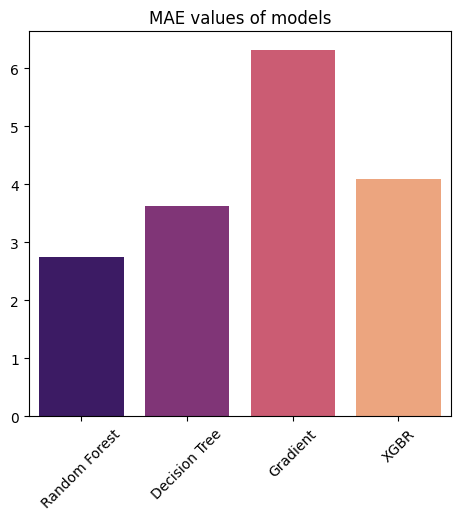

In [21]:
models = {
          "Random Forest":RandomForestRegressor(random_state=42),
          "Decision Tree":DecisionTreeRegressor(random_state=42),
          "Gradient":GradientBoostingRegressor(random_state=42),
          "XGBR":XGBRegressor(random_state=42)
          } 
mae_values= []

for name, model in models.items():
     model.fit(X_train,y_train)
     preds = model.predict(X_test)
     accuracy =mean_absolute_error(y_test,preds)
     mae_values.append(accuracy)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)

sns.barplot(x= list(models.keys()), y = mae_values, palette = "magma")
plt.title("MAE values of models")
plt.xticks(rotation=45)
plt.show()

In [22]:
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
mae = mean_absolute_error(y_test,y_pred)
print(f"MAE of Random Forest is {mae:.4f}")

MAE of Random Forest is 3.1493
